In [1]:
# all necessary includes

import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords

import os
import nltk
# nltk.download('stopwords')
from string import punctuation
from pymystem3 import Mystem
import re

In [143]:
# additional functions
mystem = Mystem()
garbage_words = stopwords.words('english') + stopwords.words('russian')

def CreateVectorizer(ngram_range, max_features):
    return CountVectorizer(analyzer = "word",
                           #min_df=5,
                           #max_df=0.7,
                           tokenizer = None,
                           preprocessor = None,
                           stop_words = None,
                           ngram_range = ngram_range,
                           max_features = max_features
                         )


def BuildDataFrame(cur_folder, doc_types, file_names, doc_texts, name=''):
    files = os.listdir()
    cur_name = name[:]
    if len(cur_name) != 0:
        cur_name += '-'
    cur_name += cur_folder
    if 'text_layer' in files:
        files.remove('text_layer')
        print('in', cur_name)
        
    folders = [file for file in files if '.' not in file]
    
    for folder in folders:
        os.chdir(folder)
        BuildDataFrame(folder, doc_types, file_names, doc_texts, cur_name)
        os.chdir('..')
    if len(folders) == 0:
        for file in files:
            text_layer = ''
            if 'text_layer' in os.listdir():
                try:
                    with open('./text_layer/' + file.split('.')[0] + '.txt') as f:
                        text_layer = f.read()
                except:
                    NOT_FOUND.append((file, cur_name))
            if len(text_layer) > 0:
                doc_texts.append(text_layer)
                doc_types.append(cur_name)
                file_names.append(file)
        

In [3]:
# build dataframe
NOT_FOUND = []
doc_types, file_names, doc_texts = [], [], []
dataset_path = 'for training'
os.chdir(dataset_path)
BuildDataFrame('', doc_types, file_names, doc_texts)
os.chdir('..')
df = pd.DataFrame({'file_name': file_names, 'doc_type': doc_types, 'doc_text' : doc_texts})

in ad-error
in ad-invoice-first
in ad-invoice-multi
in ad-statement-first
in ad-statement-multi
in ad-upd-first
in ad-upd-multi
in ad-waybill-first
in ad-waybill-multi
in rfq-AOG
in rfq-CRITICAL
in rfq-Routine
in rfq-Spam
in sec-error
in sec-Изменение контроля
in sec-Кросс-дефолт
in sec-Обозначение прав дочерних компаний
in sec-Оговорки о коллективных действиях
in sec-Ограничение деятельности
in sec-Ограничение задолженности
in sec-Ограничение задолженности дочерних компаний
in sec-Ограничение по инвестициям
in sec-Ограничение по наслоению долговых обязательств по рангам
in sec-Ограничение по платежам
in sec-Ограничение по платежам в отношении дочерних компаний
in sec-Ограничение по предоставлению залога
in sec-Ограничение по продаже активов
in sec-Ограничение по продаже активов с обратной арендой
in sec-Ограничение по слиянию
in sec-Ограничение по транзакциям с аффилированными лицами
in sec-Случаи дефолта
in sec-Триггер рейтингов
in sec-Условие приостановки действия ковенантов
in sec-

In [4]:
# part for checking files that weren't found
ext = [x[0].split('.')[-1] for x in NOT_FOUND]
print(set(ext))
formated_not_found = ['file {} at {} not found'.format(x[0], x[1]) for x in NOT_FOUND if '' in x[0].split('.')[-1].lower()]
print(len(formated_not_found))
print('\n'.join(formated_not_found))

{'jpg', 'msg', 'JPEG', 'pdf', 'PDF'}
49
file 06014769-9ae4-458d-a7cb-8ade56355dd6.pdf at ad-error not found
file 1012b487-da5b-43b3-91b5-1862e8b07c5a.pdf at ad-error not found
file 10f6b3f1-bcaa-49c6-af90-4493d6d50cbd.pdf at ad-error not found
file 19596038-1690-4aa0-84aa-162381f70581.pdf at ad-error not found
file 1e9ba652-ca81-4eec-9208-d0dfad11469b.pdf at ad-error not found
file 1f6f9a23-d9c4-4ed8-be3b-89afd4c77568.pdf at ad-error not found
file 25cbeedc-2612-4784-86de-0e139945707b.pdf at ad-error not found
file 29dcc2e1-9a68-49c1-9d43-741cf491d5dc.pdf at ad-error not found
file 2a4d3482-25d4-403b-9a0d-4b41841d44b3.pdf at ad-error not found
file 369310e4-850d-46bb-a756-151af523810a.pdf at ad-error not found
file 41aebe14-3183-46a1-b4fd-3a1513b787c7.pdf at ad-error not found
file 4889bca2-01e1-4c31-bacb-0632f36878c8.pdf at ad-error not found
file 4a753c6d-80d7-4cc9-b0e8-0192b82f0377.PDF at ad-error not found
file 51a0488a-44cd-4956-b749-998de144527b.pdf at ad-error not found
file 544

In [5]:
def ClearText(text, garbage_words):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[().,:-]', '', text).replace('\n', ' ')
    # text = ' '.join([word for word in text.lower().split() if word not in garbage_words and word.strip() not in punctuation])
    # tokens = mystem.lemmatize(text.lower())
    tokens = text.lower().split()
    tokens = [token for token in tokens if token not in garbage_words and token != ' ' and token.strip() not in punctuation]
    text = ' '.join(tokens)
    return text

In [6]:
for i in range(len(df['doc_text'])):
    df['doc_text'][i] = ClearText(df['doc_text'][i], garbage_words)
df = df.rename(columns={'doc_type' : 'target', 'doc_text' : 'X'})

In [7]:
types_list = list(set(df['target']))
types_fra = [len(df[df['target']  == tp]) / len(df) for tp in types_list]
stat = pd.DataFrame({'target': types_list, 'percentage' : types_fra}).sort_values('percentage')
stat

,target,percentage
12,sec-Ограничение по инвестициям,0.000041
24,sec-Ограничение по наслоению долговых обязател...,0.000246
17,sec-Условие приостановки действия ковенантов,0.000451
1,sec-Ограничение по платежам в отношении дочерн...,0.000451
8,sec-Ограничение по платежам,0.000492
26,sec-Обозначение прав дочерних компаний,0.000534
13,sec-Ограничение задолженности дочерних компаний,0.000534
25,sec-Ограничение по продаже активов,0.000575
7,sec-Ограничение по продаже активов с обратной ...,0.000575
27,sec-Ограничение задолженности,0.000575


In [ ]:
# split dataframe into samples with same proportion of each document class
def SplitTrainSample(dataframe, fraction=0.7):
    types = set(dataframe['target'])
    dataframes = [dataframe[dataframe['target'] == doc_type] for doc_type in types]
    splited = [np.split(df.sample(frac=1), [int(fraction * len(df))]) for df in dataframes]
    test = [df[0] for df in splited]
    train = [df[1] for df in splited]
    return pd.concat(train).sample(frac=1), pd.concat(test).sample(frac=1)

In [8]:
# split into training (0.6 of dataframe) validation (0.2 of dataframe) and test (0.2 of dataframe)

train, test = SplitTrainSample(df, fraction=0.7)

In [159]:
n_estimators = [int(x) for x in np.linspace(start=90, stop=270, num=19)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start=30, stop=170, num=15)] + [None]
min_samples_split = [int(x) for x in np.linspace(start=1, stop=25, num=6)]
min_samples_leaf = [int(x) for x in np.linspace(start=1, stop=10, num=5)]
bootstrap = [True, False]

param_dist = {
    'n_estimators' : n_estimators,
    #'max_features' : max_features,
    'max_depth' : max_depth,
    'min_samples_split' : min_samples_split,
    #'min_samples_leaf' : min_samples_leaf,
    #'bootstrap' : bootstrap,
    #'vctr__min_df' : [0.1, 1, 0.05, 0.2],
    #'vctr__max_df' : [1, 0.9, 0.7],
    #'vctr__max_features' : [10000,  30000, 50000]
}

print(param_dist)

{'n_estimators': [90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270], 'max_depth': [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, None], 'min_samples_split': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]}


In [160]:
#train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
train, test = SplitTrainSample(df, fraction=0.7)
X_train, Y_train = train['X'], train['target']
vectorizer = CreateVectorizer((1, 3), 50000)
X_train = vectorizer.fit_transform(X_train)

In [161]:
rf = RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=1)
rs = RandomizedSearchCV(rf,
                        param_dist,
                        n_iter=100,
                        cv=3,
                        verbose=3,
                        n_jobs=1,
                        random_state=0,
                        scoring='accuracy')
rs.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END max_depth=160, min_samples_split=75, n_estimators=160;, score=0.874 total time=   6.8s
[CV 2/3] END max_depth=160, min_samples_split=75, n_estimators=160;, score=0.867 total time=   7.4s
[CV 3/3] END max_depth=160, min_samples_split=75, n_estimators=160;, score=0.879 total time=   7.1s
[CV 1/3] END max_depth=80, min_samples_split=15, n_estimators=220;, score=0.882 total time=  12.8s
[CV 2/3] END max_depth=80, min_samples_split=15, n_estimators=220;, score=0.877 total time=  13.6s
[CV 3/3] END max_depth=80, min_samples_split=15, n_estimators=220;, score=0.886 total time=  13.1s
[CV 1/3] END max_depth=170, min_samples_split=80, n_estimators=90;, score=0.874 total time=   4.0s
[CV 2/3] END max_depth=170, min_samples_split=80, n_estimators=90;, score=0.868 total time=   4.1s
[CV 3/3] END max_depth=170, min_samples_split=80, n_estimators=90;, score=0.875 total time=   3.8s
[CV 1/3] END max_depth=40, min_samples_split=15, n_estimators=130;, score=0.874 total time=   6.2s
[CV 2/3

[CV 3/3] END max_depth=130, min_samples_split=35, n_estimators=220;, score=0.882 total time=  31.2s
[CV 1/3] END max_depth=140, min_samples_split=80, n_estimators=180;, score=0.875 total time=  24.2s
[CV 2/3] END max_depth=140, min_samples_split=80, n_estimators=180;, score=0.870 total time=  25.2s
[CV 3/3] END max_depth=140, min_samples_split=80, n_estimators=180;, score=0.876 total time=  24.8s
[CV 1/3] END max_depth=170, min_samples_split=45, n_estimators=110;, score=0.878 total time=  16.8s
[CV 2/3] END max_depth=170, min_samples_split=45, n_estimators=110;, score=0.871 total time=  17.7s
[CV 3/3] END max_depth=170, min_samples_split=45, n_estimators=110;, score=0.880 total time=  16.9s
[CV 1/3] END max_depth=170, min_samples_split=40, n_estimators=230;, score=0.882 total time=  39.4s
[CV 2/3] END max_depth=170, min_samples_split=40, n_estimators=230;, score=0.874 total time=  36.9s
[CV 3/3] END max_depth=170, min_samples_split=40, n_estimators=230;, score=0.882 total time=  11.5s


[CV 2/3] END max_depth=100, min_samples_split=25, n_estimators=240;, score=0.873 total time=  50.3s
[CV 3/3] END max_depth=100, min_samples_split=25, n_estimators=240;, score=0.885 total time=  40.1s
[CV 1/3] END max_depth=110, min_samples_split=40, n_estimators=140;, score=0.877 total time=   7.0s
[CV 2/3] END max_depth=110, min_samples_split=40, n_estimators=140;, score=0.872 total time=   7.5s
[CV 3/3] END max_depth=110, min_samples_split=40, n_estimators=140;, score=0.881 total time=   7.2s
[CV 1/3] END max_depth=110, min_samples_split=60, n_estimators=150;, score=0.879 total time=   6.9s
[CV 2/3] END max_depth=110, min_samples_split=60, n_estimators=150;, score=0.870 total time=   7.4s
[CV 3/3] END max_depth=110, min_samples_split=60, n_estimators=150;, score=0.878 total time=   6.8s
[CV 1/3] END max_depth=110, min_samples_split=30, n_estimators=220;, score=0.880 total time=  11.9s
[CV 2/3] END max_depth=110, min_samples_split=30, n_estimators=220;, score=0.872 total time=  17.6s


[CV 1/3] END max_depth=70, min_samples_split=50, n_estimators=170;, score=0.877 total time=   7.5s
[CV 2/3] END max_depth=70, min_samples_split=50, n_estimators=170;, score=0.870 total time=   8.0s
[CV 3/3] END max_depth=70, min_samples_split=50, n_estimators=170;, score=0.875 total time=   7.8s
[CV 1/3] END max_depth=80, min_samples_split=35, n_estimators=250;, score=0.876 total time=  25.1s
[CV 2/3] END max_depth=80, min_samples_split=35, n_estimators=250;, score=0.872 total time=  43.7s
[CV 3/3] END max_depth=80, min_samples_split=35, n_estimators=250;, score=0.883 total time=  40.6s
[CV 1/3] END max_depth=90, min_samples_split=30, n_estimators=230;, score=0.883 total time=  38.6s
[CV 2/3] END max_depth=90, min_samples_split=30, n_estimators=230;, score=0.875 total time=  42.7s
[CV 3/3] END max_depth=90, min_samples_split=30, n_estimators=230;, score=0.887 total time=  40.6s
[CV 1/3] END max_depth=170, min_samples_split=65, n_estimators=90;, score=0.875 total time=   8.2s
[CV 2/3] E

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(bootstrap=False,
                                                    max_features='sqrt'),
                   n_iter=100, n_jobs=1,
                   param_distributions={'max_depth': [30, 40, 50, 60, 70, 80,
                                                      90, 100, 110, 120, 130,
                                                      140, 150, 160, 170,
                                                      None],
                                        'min_samples_split': [10, 15, 20, 25,
                                                              30, 35, 40, 45,
                                                              50, 55, 60, 65,
                                                              70, 75, 80],
                                        'n_estimators': [90, 100, 110, 120, 130,
                                                         140, 150, 160, 170,
                                 

In [162]:
rs.best_params_

{'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 150}

In [163]:
def GetResultsDataFrame(searcher):
    searcher_df = pd.DataFrame(searcher.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    searcher_df = searcher_df.drop([
        'mean_fit_time',
        'std_fit_time',
        'std_score_time',
        'mean_score_time',
        'params',
        'split0_test_score',
        'split1_test_score',
        'split2_test_score',
        'std_test_score'
    ], axis=1)
    return searcher_df

In [164]:
rs_df = GetResultsDataFrame(rs)
rs_df.head(20)

,param_n_estimators,param_min_samples_split,param_max_depth,mean_test_score,rank_test_score
0,130,15,160,0.885203,1
1,200,10,150,0.885203,1
2,230,15,None,0.884248,3
3,250,15,130,0.884111,4
4,90,10,140,0.883838,5
5,140,10,80,0.883429,6
6,250,20,100,0.882883,7
7,220,15,80,0.881654,8
8,230,30,90,0.881654,9
9,160,25,None,0.881108,10


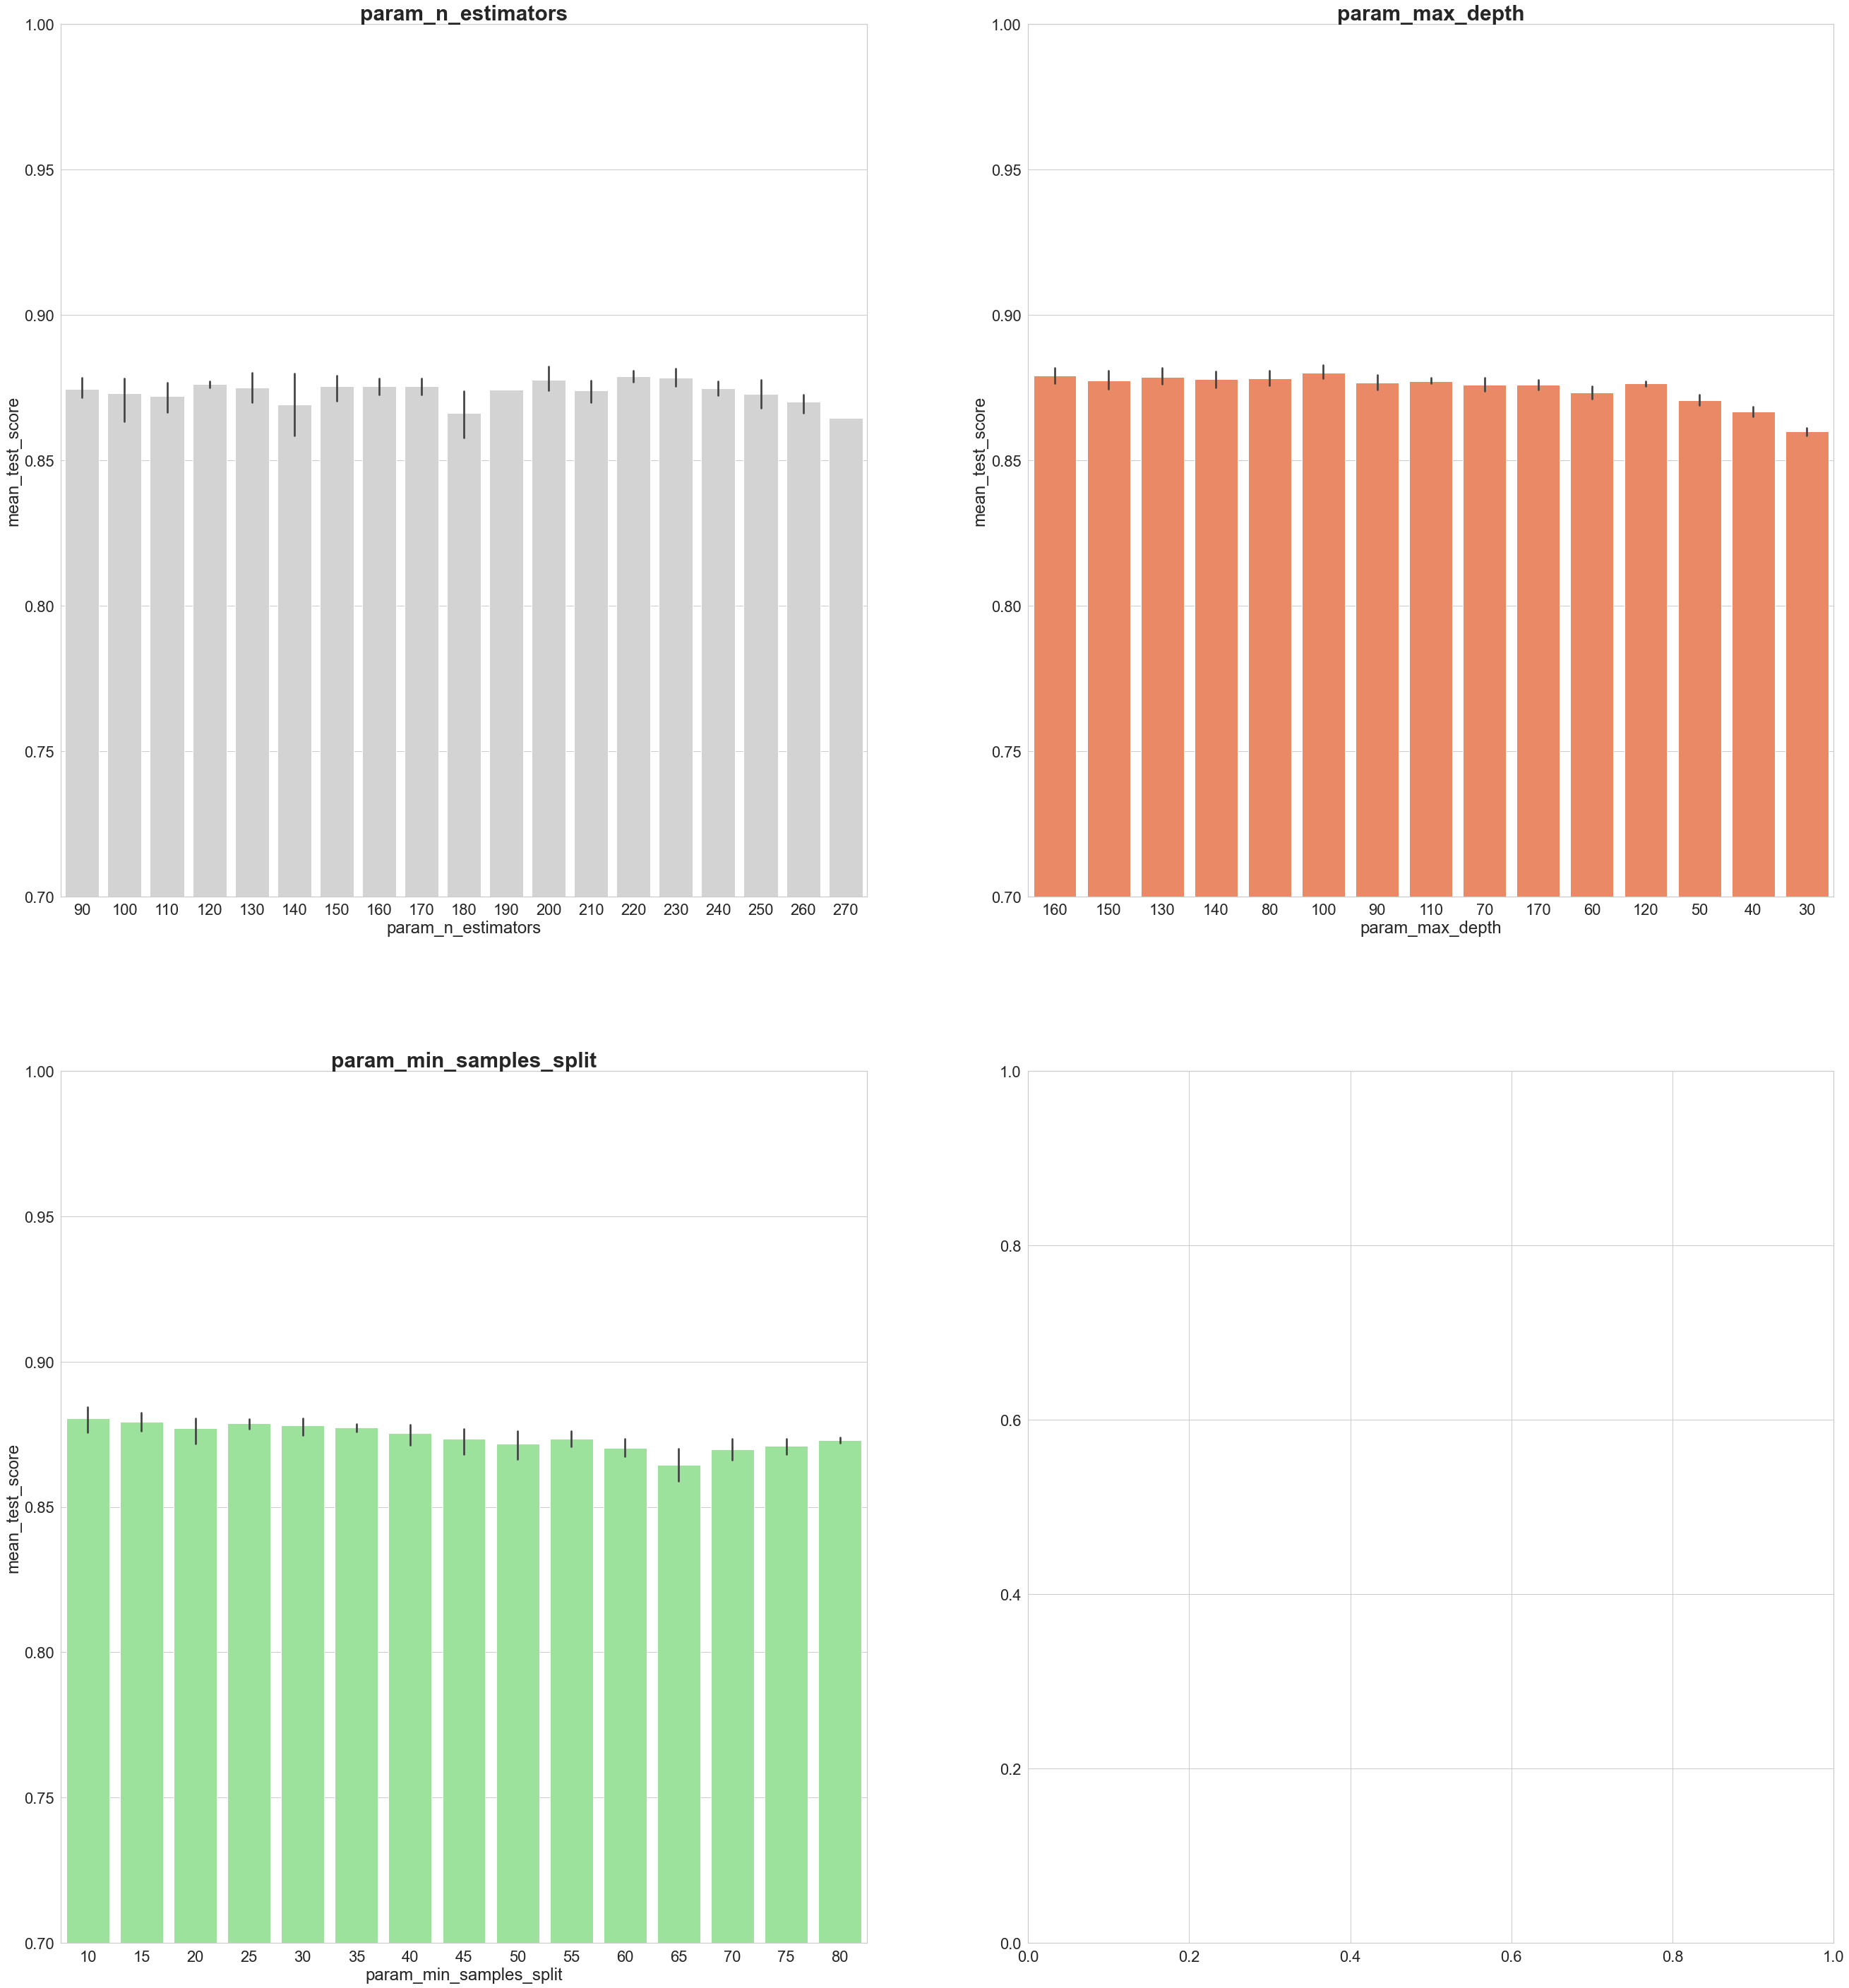

In [165]:
colors = ['lightgrey', 'coral', 'lightgreen', 'wheat', 'lightpink', 
          'skyblue', 'forestgreen', 'maroon', 'olivedrab']
params = ['param_' + x for x in list(param_dist.keys())]
ncols, nrows = 2, len(params) // 2 + len(params) % 2
fig, axs = plt.subplots(ncols=ncols, nrows=nrows)
sns.set(style="whitegrid", color_codes=True, font_scale=2)
fig.set_size_inches(45, 50)

for ind in range(len(params)):
    i = ind // ncols
    j = ind % ncols
    sns.barplot(x=params[ind], y='mean_test_score', data=rs_df, ax=axs[i, j], color=colors[ind])
    axs[i, j].set_ylim([.7, 1])
    axs[i, j].set_title(label=params[ind], size=30, weight='bold')

plt.show()

In [166]:
def CalculateAccuracy(model, vectorizer, ds, confidence_level):
    ds['predict'] = model.predict(vectorizer.transform(ds['X']))
    ds['confidence'] = np.transpose(np.amax(model.predict_proba(vectorizer.transform(ds['X'])), axis=1))
    mean_confidence = np.mean(ds['confidence']) #np.mean(model.predict_proba(vectorizer.transform(ds['X'])))
    precision = round(100 * len(ds[(ds['confidence'] >= confidence_level) & (ds['target'] == ds['predict'])]) / len(ds), 2)
    to_validate = round(100 * len(ds[(ds['confidence'] < confidence_level)]) / len(ds), 2)
    return precision, to_validate, mean_confidence


def ShowStatistics(model_, vectorizer_, to_show_model=True):
    if to_show_model:
        print('model:', model_)
        print('vectorizer:', vectorizer_)
    precision, to_validate, mean_confidence = CalculateAccuracy(model_, vectorizer_, test.copy(), 0.8)
    prediction = model_.predict(vectorizer_.transform(test['X']))
    print('Rows in test set: {}'.format(len(test)))
    print('Statistics:')
    print('Precision = {}%; Ratio to validate = {}%; at confidence level = {}'.format(precision, to_validate, 0.8))
    print('Mean accuracy: {}%'.format(round(100 * accuracy_score(test['target'], prediction), 2)))
    print('Mean confidence: {}%'.format(round(100 * mean_confidence, 2)))
    print(classification_report(test['target'], prediction))

In [167]:
rs.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=150, max_features='sqrt',
                       min_samples_split=10, n_estimators=200)

In [168]:
ShowStatistics(rs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=150, max_features='sqrt',
                       min_samples_split=10, n_estimators=200)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Statistics:
Precision = 75.08%; Ratio to validate = 22.46%; at confidence level = 0.8
Mean accuracy: 89.6%
Mean confidence: 87.49%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.93      0.93      0.93      2931
                                            ad-invoice-multi       0.90      0.73      0.81       359
                                          ad-statement-first       0.99      0.99      0.99      3929
                                          ad-statement-multi       0.98      0.92      0.95       524
                                                ad-upd-first       0.90      0.95      0.92      2488
                  

In [169]:
def GetBestArgs(rs_df, param):
    a = rs_df.groupby(param).mean_test_score.mean().to_dict()
    srtd = [(a[key], key) for key in a.keys()]
    srtd.sort(key=lambda x: -x[0])
    srtd = [x[1] for x in srtd]
    return srtd

In [170]:
best_n_estimators = GetBestArgs(rs_df, 'param_n_estimators')[:5]
#best_max_features = GetBestArgs(rs_df, 'param_max_features')[:1]
best_max_depth = [None] + GetBestArgs(rs_df, 'param_max_depth')[:4]
best_min_samples_split = GetBestArgs(rs_df, 'param_min_samples_split')[:4]
#best_min_samples_leaf = GetBestArgs(rs_df, 'param_min_samples_leaf')[:3]
#best_bootstrap = [False, True]

#best_min_df = GetBestArgs(rs_df, 'param_vctr__min_df')[:2]
#best_max_df = GetBestArgs(rs_df, 'param_vctr__max_df')[:2]
param_grid = {
    'n_estimators' : best_n_estimators,
    #'max_features' : best_max_features,
    'max_depth' : best_max_depth,
    'min_samples_split' : best_min_samples_split,
    #'min_samples_leaf' : best_min_samples_leaf,
    #'bootstrap' : best_bootstrap,
    #'vctr__min_df' : best_min_df,
    #'vctr__max_df' : best_max_df
}

print(param_grid)

{'n_estimators': [220, 230, 200, 120, 160], 'max_depth': [None, 100, 160, 130, 80], 'min_samples_split': [10, 15, 25, 30]}


In [171]:
#train, test = np.split(df.sample(frac=1), [int(0.8 * len(df))])
train, test = SplitTrainSample(df, fraction=0.7)
X_train, Y_train = train['X'], train['target']
vectorizer = CreateVectorizer((1, 3), 50000)
X_train = vectorizer.fit_transform(X_train)

In [172]:
rf = RandomForestClassifier(bootstrap=False, max_features='sqrt', min_samples_leaf=1)
gs = GridSearchCV(rf, param_grid, cv=3, verbose=3, n_jobs=1)
gs.fit(X_train, Y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


[CV 1/3] END max_depth=None, min_samples_split=10, n_estimators=220;, score=0.888 total time=  18.1s
[CV 2/3] END max_depth=None, min_samples_split=10, n_estimators=220;, score=0.885 total time=  39.2s
[CV 3/3] END max_depth=None, min_samples_split=10, n_estimators=220;, score=0.882 total time=  58.3s
[CV 1/3] END max_depth=None, min_samples_split=10, n_estimators=230;, score=0.887 total time= 1.1min
[CV 2/3] END max_depth=None, min_samples_split=10, n_estimators=230;, score=0.888 total time= 1.2min
[CV 3/3] END max_depth=None, min_samples_split=10, n_estimators=230;, score=0.885 total time=  29.4s
[CV 1/3] END max_depth=None, min_samples_split=10, n_estimators=200;, score=0.887 total time=  16.2s
[CV 2/3] END max_depth=None, min_samples_split=10, n_estimators=200;, score=0.887 total time=  17.7s
[CV 3/3] END max_depth=None, min_samples_split=10, n_estimators=200;, score=0.882 total time=  15.3s
[CV 1/3] END max_depth=None, min_samples_split=10, n_estimators=120;, score=0.887 total tim

[CV 2/3] END max_depth=100, min_samples_split=15, n_estimators=200;, score=0.885 total time=  35.5s
[CV 3/3] END max_depth=100, min_samples_split=15, n_estimators=200;, score=0.880 total time=  12.2s
[CV 1/3] END max_depth=100, min_samples_split=15, n_estimators=120;, score=0.888 total time=   7.7s
[CV 2/3] END max_depth=100, min_samples_split=15, n_estimators=120;, score=0.887 total time=   8.0s
[CV 3/3] END max_depth=100, min_samples_split=15, n_estimators=120;, score=0.880 total time=   7.4s
[CV 1/3] END max_depth=100, min_samples_split=15, n_estimators=160;, score=0.889 total time=  10.0s
[CV 2/3] END max_depth=100, min_samples_split=15, n_estimators=160;, score=0.886 total time=  10.4s
[CV 3/3] END max_depth=100, min_samples_split=15, n_estimators=160;, score=0.879 total time=  13.3s
[CV 1/3] END max_depth=100, min_samples_split=25, n_estimators=220;, score=0.885 total time=  43.6s
[CV 2/3] END max_depth=100, min_samples_split=25, n_estimators=220;, score=0.888 total time=  40.9s


[CV 3/3] END max_depth=160, min_samples_split=25, n_estimators=160;, score=0.879 total time=  30.0s
[CV 1/3] END max_depth=160, min_samples_split=30, n_estimators=220;, score=0.886 total time=  38.5s
[CV 2/3] END max_depth=160, min_samples_split=30, n_estimators=220;, score=0.889 total time=  35.5s
[CV 3/3] END max_depth=160, min_samples_split=30, n_estimators=220;, score=0.878 total time=  10.8s
[CV 1/3] END max_depth=160, min_samples_split=30, n_estimators=230;, score=0.884 total time=  12.5s
[CV 2/3] END max_depth=160, min_samples_split=30, n_estimators=230;, score=0.885 total time=  12.2s
[CV 3/3] END max_depth=160, min_samples_split=30, n_estimators=230;, score=0.878 total time=  11.2s
[CV 1/3] END max_depth=160, min_samples_split=30, n_estimators=200;, score=0.885 total time=  10.6s
[CV 2/3] END max_depth=160, min_samples_split=30, n_estimators=200;, score=0.883 total time=  14.6s
[CV 3/3] END max_depth=160, min_samples_split=30, n_estimators=200;, score=0.876 total time=  33.1s


[CV 1/3] END max_depth=80, min_samples_split=10, n_estimators=200;, score=0.888 total time=  53.6s
[CV 2/3] END max_depth=80, min_samples_split=10, n_estimators=200;, score=0.885 total time=  37.7s
[CV 3/3] END max_depth=80, min_samples_split=10, n_estimators=200;, score=0.886 total time=  15.0s
[CV 1/3] END max_depth=80, min_samples_split=10, n_estimators=120;, score=0.886 total time=   9.5s
[CV 2/3] END max_depth=80, min_samples_split=10, n_estimators=120;, score=0.887 total time=  10.3s
[CV 3/3] END max_depth=80, min_samples_split=10, n_estimators=120;, score=0.881 total time=   8.9s
[CV 1/3] END max_depth=80, min_samples_split=10, n_estimators=160;, score=0.887 total time=  12.6s
[CV 2/3] END max_depth=80, min_samples_split=10, n_estimators=160;, score=0.885 total time=  39.2s
[CV 3/3] END max_depth=80, min_samples_split=10, n_estimators=160;, score=0.884 total time=  40.0s
[CV 1/3] END max_depth=80, min_samples_split=15, n_estimators=220;, score=0.886 total time=  46.7s
[CV 2/3] E

In [ ]:
print(gs.best_estimator_)
print(gs.best_params_)

In [173]:
gs_df = GetResultsDataFrame(gs)
gs_df.head(20)

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,rank_test_score
0,160,10,200,0.887114,1
1,None,15,160,0.886978,2
2,130,10,230,0.886705,3
3,None,10,230,0.886705,3
4,160,10,220,0.886568,5
5,100,10,220,0.886432,6
6,130,10,220,0.886295,7
7,80,10,200,0.886295,8
8,None,15,200,0.886159,9
9,130,10,120,0.886159,9


In [174]:
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=160, max_features='sqrt',
                       min_samples_split=10, n_estimators=200)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Statistics:
Precision = 74.72%; Ratio to validate = 22.61%; at confidence level = 0.8
Mean accuracy: 89.8%
Mean confidence: 87.37%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.93      0.93      2931
                                            ad-invoice-multi       0.87      0.70      0.78       359
                                          ad-statement-first       0.97      0.99      0.98      3929
                                          ad-statement-multi       0.97      0.89      0.93       524
                                                ad-upd-first       0.89      0.96      0.92      2488
                                                ad-upd-multi       0.91      0.76      0.83       520
                                            ad-waybill-first       0.94      0.96      0.95       985
                                            ad-waybill-multi       1.00      0.65      0.79       139
                                                     rfq-AOG       0.84      0.61

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [158]:
# amount of zero-precision reduced
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=170, max_features='sqrt',
                       min_samples_split=10, n_estimators=190)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 17041
Statistics:
Precision = 75.21%; Ratio to validate = 21.95%; at confidence level = 0.8
Mean accuracy: 89.34%
Mean confidence: 87.67%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.92      0.93      0.92      2931
                                            ad-invoice-multi       0.93      0.72      0.81       359
                                          ad-statement-first       0.97      0.99      0.98      3929
                                          ad-statement-multi       0.98      0.87      0.92       524
                                                ad-upd-first       0.90      0.93      0.91      2488
                                                ad-upd-multi       0.88      0.81      0.85       520
                                            ad-waybill-first       0.95      0.95      0.95       985
                                            ad-waybill-multi       1.00      0.68      0.81       139
                                                     rfq-AOG       0.86      0.57

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [141]:
# good precision
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_depth=160, max_features='sqrt',
                       min_samples_split=10, n_estimators=200)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 77.84%; Ratio to validate = 19.86%; at confidence level = 0.8
Mean accuracy: 90.83%
Mean confidence: 89.16%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.95      0.94      0.94       864
                                            ad-invoice-multi       0.94      0.73      0.83       116
                                          ad-statement-first       0.98      0.99      0.99      1135
                                          ad-statement-multi       0.97      0.91      0.94       149
                                                ad-upd-first       0.92      0.96      0.94       689
                  

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
# good macro avg
ShowStatistics(gs.best_estimator_, vectorizer)

model: RandomForestClassifier(max_depth=130, min_samples_split=10, n_estimators=120)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 75.48%; Ratio to validate = 22.38%; at confidence level = 0.8
Mean accuracy: 89.95%
Mean confidence: 87.63%


C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.94      0.93      0.94       828
                                            ad-invoice-multi       0.98      0.67      0.79       127
                                          ad-statement-first       0.98      0.99      0.99      1148
                                          ad-statement-multi       0.98      0.92      0.95       160
                                                ad-upd-first       0.90      0.95      0.92       714
                                                ad-upd-multi       0.85      0.83      0.84       149
                                            ad-waybill-first       0.94      0.97      0.95       293
                                            ad-waybill-multi       0.96      0.68      0.79        34
                                                     rfq-AOG       0.82      0.57

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# write model to file
if 'models' not in os.listdir():
    os.mkdir('models')
with open('./models/doc_classifyer-model', 'wb') as f:
    pickle.dump(model, f)
with open('./models/doc_classifyer-vectorizer', 'wb') as f:
    pickle.dump(vectorizer, f)

In [100]:
# read model from file
with open('./models/doc_classifyer-model', 'rb') as f:
    model = pickle.load(f)
with open('./models/doc_classifyer-vectorizer', 'rb') as f:
    vectorizer = pickle.load(f)

In [101]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 67.42%; Ratio to validate = 32.11%; at confidence level = 0.8
Mean accuracy: 91.49%
Mean confidence: 84.14%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.97      0.94      0.96       828
                                            ad-invoice-multi       0.97      0.72      0.82       127
                                          ad-statement-first       0.99      1.00      0.99      1148
                                          ad-statement-multi       0.99      0.96      0.97       160
                                                ad-upd-first       0.91      0.99      0.95       714
                                 

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 67.77%; Ratio to validate = 31.64%; at confidence level = 0.8
Mean accuracy: 92.53%
                                                              precision    recall  f1-score   support

                                            ad-invoice-first       0.98      0.94      0.96       812
                                            ad-invoice-multi       0.94      0.80      0.86        99
                                          ad-statement-first       0.99      1.00      0.99      1157
                                          ad-statement-multi       0.99      0.95      0.97       164
                                                ad-upd-first       0.92      0.99      0.95       719
                                                ad-upd-mu

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
ShowStatistics(model, vectorizer)

model: RandomForestClassifier(bootstrap=False, max_features='sqrt',
                       min_samples_split=20, n_estimators=127)
vectorizer: CountVectorizer(max_features=50000, ngram_range=(1, 3))
Rows in test set: 4874
Statistics:
Precision = 68.86%; Ratio to validate = 30.84%; at confidence level = 0.8
Mean accuracy: 91.61%
                                                           precision    recall  f1-score   support

                                         ad-invoice-first       0.98      0.93      0.96       831
                                         ad-invoice-multi       0.96      0.77      0.85        94
                                       ad-statement-first       0.99      1.00      0.99      1154
                                       ad-statement-multi       0.98      0.93      0.96       132
                                             ad-upd-first       0.89      0.99      0.94       712
                                             ad-upd-multi       0.96      0

C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\otrm\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
